In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve



In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator26 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator26)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator26)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator26)
country1 = Country('DE', 1, regulator= Regulator26)
country2 = Country('FI', 0.5, regulator= Regulator26)
country3 = Country('GR', size= 0.1, regulator= Regulator26)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator26)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator26)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator26)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator26)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator26)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator26)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator26)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator26)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator26)



In [3]:
Regulator26.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
# Define the percentages of BAU emissions
cases = [True]
Regulator26.emission_cap = Regulator26.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {case: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'permits1': [], 'permits2': [], 'trades1': [], 'trades2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': []
} for case in cases}

# Loop over each percentage
for case in cases:

    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
        Regulator26.emission_cap = Regulator26.BAU_emissions * free
        Regulator26.optimization_concave_formulation_ab()
        # Regulator26.optimization_with_least_squares_ab()
        print(f"{free}: {Regulator26.equilibrium_tester(output=True)}")

        for firm in Regulator26.firm_registry.values():
            firm.calculate_profit_components()

        results[case]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[case]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[case]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[case]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[case]['permits1'].append(mean(float(i.permits_used) for i in sector1.firms))
        results[case]['permits2'].append(mean(float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[case]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[case]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[case]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[case]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[case]['permit_price'].append(Regulator26.permit_price)
        results[case]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[case]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[case]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[case]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:01<03:05,  1.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      | +101.5139 ⚠️ |  +7.56e-6 ✔️ |  -68.9139 ✔️ |  -69.1139 ✔️ |  +13.7828 ✔️ | 4/5
0.0: (False, 101.513886037773)
Optimal solution found


  2%|▏         | 2/100 [00:03<03:07,  1.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +97.1076 ⚠️ |  +9.61e-6 ✔️ |  -68.1468 ✔️ |  -68.3468 ✔️ |  +13.6294 ✔️ | 4/5
0.010101010101010102: (False, 97.1075903943392)
Optimal solution found


  3%|▎         | 3/100 [00:05<03:10,  1.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +90.6042 ⚠️ |  +1.19e-5 ✔️ |  -66.9986 ✔️ |  -67.1986 ✔️ |  +13.3997 ✔️ | 4/5
0.020202020202020204: (False, 90.6042100639372)
Optimal solution found


  4%|▍         | 4/100 [00:07<03:15,  2.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +82.5289 ⚠️ |  +6.55e-6 ✔️ |  -65.5452 ✔️ |  -65.7452 ✔️ |  +13.1090 ✔️ | 4/5
0.030303030303030304: (False, 82.5288613012023)
Optimal solution found


  5%|▌         | 5/100 [00:10<03:23,  2.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +73.1606 ⚠️ |  +1.72e-7 ✔️ |  -63.8177 ✔️ |  -64.0177 ✔️ |  +12.7635 ✔️ | 4/5
0.04040404040404041: (False, 73.1605925486747)
Optimal solution found


  6%|▌         | 6/100 [00:15<04:58,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +62.6612 ⚠️ |  +7.92e-6 ✔️ |  -61.8249 ✔️ |  -62.0249 ✔️ |  +12.3650 ✔️ | 4/5
0.05050505050505051: (False, 62.6611893994587)
Optimal solution found


  7%|▋         | 7/100 [00:18<04:51,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +51.1347 ⚠️ |  +6.57e-6 ✔️ |  -59.5608 ✔️ |  -59.7608 ✔️ |  +11.9122 ✔️ | 4/5
0.06060606060606061: (False, 51.1346514134064)
Optimal solution found


  8%|▊         | 8/100 [00:21<04:40,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +48.1186 ⚠️ |  +8.71e-6 ✔️ |  -58.9541 ✔️ |  -59.1541 ✔️ |  +11.7908 ✔️ | 4/5
0.07070707070707072: (False, 48.1185729603102)
Optimal solution found


  9%|▉         | 9/100 [00:23<04:19,  2.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +45.7041 ⚠️ |  +2.48e-6 ✔️ |  -58.4639 ✔️ |  -58.6639 ✔️ |  +11.6928 ✔️ | 4/5
0.08080808080808081: (False, 45.7041104413469)
Optimal solution found


 10%|█         | 10/100 [00:26<04:14,  2.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +43.2749 ⚠️ |  +8.35e-6 ✔️ |  -57.9666 ✔️ |  -58.1666 ✔️ |  +11.5933 ✔️ | 4/5
0.09090909090909091: (False, 43.2749459725085)
Optimal solution found


 11%|█         | 11/100 [00:31<05:10,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +40.8430 ⚠️ |  +2.45e-6 ✔️ |  -57.4645 ✔️ |  -57.6645 ✔️ |  +11.4929 ✔️ | 4/5
0.10101010101010102: (False, 40.8429905902572)
Optimal solution found


 12%|█▏        | 12/100 [00:36<05:32,  3.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +38.4125 ⚠️ |  +1.81e-5 ✔️ |  -56.9582 ✔️ |  -57.1582 ✔️ |  +11.3916 ✔️ | 4/5
0.11111111111111112: (False, 38.4124970852069)
Optimal solution found


 13%|█▎        | 13/100 [00:38<04:54,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +35.9728 ⚠️ |  +6.43e-6 ✔️ |  -56.4455 ✔️ |  -56.6455 ✔️ |  +11.2891 ✔️ | 4/5
0.12121212121212122: (False, 35.9728292473748)
Optimal solution found


 14%|█▍        | 14/100 [00:41<04:28,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +33.5225 ⚠️ |  +5.61e-6 ✔️ |  -55.9258 ✔️ |  -56.1258 ✔️ |  +11.1852 ✔️ | 4/5
0.13131313131313133: (False, 33.5225091337070)
Optimal solution found


 15%|█▌        | 15/100 [00:44<04:21,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +31.0699 ⚠️ |  +7.70e-6 ✔️ |  -55.4009 ✔️ |  -55.6009 ✔️ |  +11.0802 ✔️ | 4/5
0.14141414141414144: (False, 31.0698944234995)
Optimal solution found


 16%|█▌        | 16/100 [00:48<04:43,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +28.6150 ⚠️ |  +9.86e-6 ✔️ |  -54.8704 ✔️ |  -55.0704 ✔️ |  +10.9741 ✔️ | 4/5
0.15151515151515152: (False, 28.6150153065830)
Optimal solution found


 17%|█▋        | 17/100 [00:50<04:23,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +26.1577 ⚠️ |  +8.27e-6 ✔️ |  -54.3343 ✔️ |  -54.5343 ✔️ |  +10.8669 ✔️ | 4/5
0.16161616161616163: (False, 26.1576729182679)
Optimal solution found


 18%|█▊        | 18/100 [00:55<04:51,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +23.6833 ⚠️ |  +1.11e-5 ✔️ |  -53.7891 ✔️ |  -53.9891 ✔️ |  +10.7578 ✔️ | 4/5
0.17171717171717174: (False, 23.6833301499259)
Optimal solution found


 19%|█▉        | 19/100 [00:57<04:22,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +21.2075 ⚠️ |  +4.43e-6 ✔️ |  -53.2380 ✔️ |  -53.4380 ✔️ |  +10.6476 ✔️ | 4/5
0.18181818181818182: (False, 21.2075429662110)
Optimal solution found


 20%|██        | 20/100 [01:01<04:22,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +18.7337 ⚠️ |   +0.0040 ⚠️ |  -52.6817 ✔️ |  -52.8817 ✔️ |  +10.5363 ✔️ | 3/5
0.19191919191919193: (False, 18.7336841590104)
Optimal solution found


 21%|██        | 21/100 [01:05<04:55,  3.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +16.2580 ⚠️ |  +4.50e-6 ✔️ |  -52.1190 ✔️ |  -52.3190 ✔️ |  +10.4238 ✔️ | 4/5
0.20202020202020204: (False, 16.2580080461537)
Optimal solution found


 22%|██▏       | 22/100 [01:08<04:29,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +13.7805 ⚠️ |  +7.09e-6 ✔️ |  -51.5498 ✔️ |  -51.7498 ✔️ |  +10.3100 ✔️ | 4/5
0.21212121212121213: (False, 13.7805188732425)
Optimal solution found


 23%|██▎       | 23/100 [01:12<04:39,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +11.2885 ⚠️ |  +1.03e-5 ✔️ |  -50.9709 ✔️ |  -51.1709 ✔️ |  +10.1942 ✔️ | 4/5
0.22222222222222224: (False, 11.2884884230762)
Optimal solution found


 24%|██▍       | 24/100 [01:16<04:35,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +8.7931 ⚠️ |  +1.67e-5 ✔️ |  -50.3847 ✔️ |  -50.5847 ✔️ |  +10.0769 ✔️ | 4/5
0.23232323232323235: (False, 8.79305378158755)
Optimal solution found


 25%|██▌       | 25/100 [01:20<04:51,  3.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +6.2961 ⚠️ |  +2.42e-5 ✔️ |  -49.7912 ✔️ |  -49.9912 ✔️ |   +9.9582 ✔️ | 4/5
0.24242424242424243: (False, 6.29608322069775)
Optimal solution found


 26%|██▌       | 26/100 [01:24<04:39,  3.77s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +3.7976 ⚠️ |  +8.13e-6 ✔️ |  -49.1902 ✔️ |  -49.3902 ✔️ |   +9.8380 ✔️ | 4/5
0.25252525252525254: (False, 3.79755245220311)
Optimal solution found


 27%|██▋       | 27/100 [01:28<04:52,  4.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +1.2972 ⚠️ |  +1.00e-5 ✔️ |  -48.5814 ✔️ |  -48.7814 ✔️ |   +9.7163 ✔️ | 4/5
0.26262626262626265: (False, 1.29723752759531)
Optimal solution found


 28%|██▊       | 28/100 [01:32<04:30,  3.75s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +4.09e-4 ✔️ |  +3.65e-6 ✔️ |  -48.1013 ✔️ |  -48.3013 ✔️ |   +9.6203 ✔️ | 5/5
0.27272727272727276: (True, 0.000409481601607808)
Optimal solution found


 29%|██▉       | 29/100 [01:35<04:14,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0038 ⚠️ |  +2.57e-5 ✔️ |  -47.7619 ✔️ |  -47.9619 ✔️ |   +9.5524 ✔️ | 4/5
0.2828282828282829: (False, 0.00383221018523017)
Optimal solution found


 30%|███       | 30/100 [01:38<03:54,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0300 ⚠️ |  +2.18e-5 ✔️ |  -47.4194 ✔️ |  -47.6194 ✔️ |   +9.4839 ✔️ | 4/5
0.29292929292929293: (False, 0.0299892739736975)
Optimal solution found


 31%|███       | 31/100 [01:41<03:49,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0408 ⚠️ |  +1.81e-5 ✔️ |  -47.0747 ✔️ |  -47.2747 ✔️ |   +9.4149 ✔️ | 4/5
0.30303030303030304: (False, 0.0408197124513663)
Optimal solution found


 32%|███▏      | 32/100 [01:44<03:50,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0467 ⚠️ |  +2.21e-5 ✔️ |  -46.7274 ✔️ |  -46.9274 ✔️ |   +9.3455 ✔️ | 4/5
0.31313131313131315: (False, 0.0467211064738962)
Optimal solution found


 33%|███▎      | 33/100 [01:48<03:41,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0502 ⚠️ |  +4.52e-6 ✔️ |  -46.3774 ✔️ |  -46.5774 ✔️ |   +9.2755 ✔️ | 4/5
0.32323232323232326: (False, 0.0501665091238195)
Optimal solution found


 34%|███▍      | 34/100 [01:51<03:48,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0504 ⚠️ |  +5.94e-6 ✔️ |  -46.0248 ✔️ |  -46.2248 ✔️ |   +9.2050 ✔️ | 4/5
0.33333333333333337: (False, 0.0504218851492411)
Optimal solution found


 35%|███▌      | 35/100 [01:54<03:36,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0475 ⚠️ |  +6.61e-6 ✔️ |  -45.6694 ✔️ |  -45.8694 ✔️ |   +9.1339 ✔️ | 4/5
0.3434343434343435: (False, 0.0475123131471236)
Optimal solution found


 36%|███▌      | 36/100 [01:59<03:55,  3.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0415 ⚠️ |  +9.35e-6 ✔️ |  -45.3112 ✔️ |  -45.5112 ✔️ |   +9.0622 ✔️ | 4/5
0.3535353535353536: (False, 0.0414541177170307)
Optimal solution found


 37%|███▋      | 37/100 [02:02<03:38,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0323 ⚠️ |  +2.76e-7 ✔️ |  -44.9501 ✔️ |  -45.1501 ✔️ |   +8.9900 ✔️ | 4/5
0.36363636363636365: (False, 0.0323079914921962)
Optimal solution found


 38%|███▊      | 38/100 [02:05<03:21,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0201 ⚠️ |  +2.39e-6 ✔️ |  -44.5861 ✔️ |  -44.7861 ✔️ |   +8.9172 ✔️ | 4/5
0.37373737373737376: (False, 0.0201025427602985)
Optimal solution found


 39%|███▉      | 39/100 [02:09<03:37,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0049 ⚠️ |  +3.66e-6 ✔️ |  -44.2190 ✔️ |  -44.4190 ✔️ |   +8.8438 ✔️ | 4/5
0.38383838383838387: (False, 0.00487908433581197)
Optimal solution found


 40%|████      | 40/100 [02:12<03:27,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0133 ⚠️ |  +1.02e-5 ✔️ |  -43.8489 ✔️ |  -44.0489 ✔️ |   +8.7698 ✔️ | 4/5
0.393939393939394: (False, 0.0133330422804008)
Optimal solution found


 41%|████      | 41/100 [02:16<03:37,  3.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0345 ⚠️ |  +6.50e-6 ✔️ |  -43.4756 ✔️ |  -43.6756 ✔️ |   +8.6951 ✔️ | 4/5
0.4040404040404041: (False, 0.0344868264699940)
Optimal solution found


 42%|████▏     | 42/100 [02:19<03:15,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0229 ⚠️ |  +5.20e-6 ✔️ |  -43.0981 ✔️ |  -43.2981 ✔️ |   +8.6196 ✔️ | 4/5
0.4141414141414142: (False, 0.0228676651110931)
Optimal solution found


 43%|████▎     | 43/100 [02:23<03:23,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0028 ⚠️ |  +1.07e-5 ✔️ |  -42.7171 ✔️ |  -42.9171 ✔️ |   +8.5434 ✔️ | 4/5
0.42424242424242425: (False, 0.00282592272802162)
Optimal solution found


 44%|████▍     | 44/100 [02:27<03:22,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0145 ⚠️ |  +2.06e-9 ✔️ |  -42.3326 ✔️ |  -42.5326 ✔️ |   +8.4665 ✔️ | 4/5
0.43434343434343436: (False, 0.0144687427356089)
Optimal solution found


 45%|████▌     | 45/100 [02:30<03:08,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0290 ⚠️ |  +2.48e-5 ✔️ |  -41.9445 ✔️ |  -42.1445 ✔️ |   +8.3889 ✔️ | 4/5
0.4444444444444445: (False, 0.0290474728076404)
Optimal solution found


 46%|████▌     | 46/100 [02:33<02:59,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0417 ⚠️ |  +2.82e-5 ✔️ |  -41.5529 ✔️ |  -41.7529 ✔️ |   +8.3106 ✔️ | 4/5
0.4545454545454546: (False, 0.0416928334789262)
Optimal solution found


 47%|████▋     | 47/100 [02:37<03:03,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0502 ⚠️ |  +9.42e-6 ✔️ |  -41.1575 ✔️ |  -41.3575 ✔️ |   +8.2315 ✔️ | 4/5
0.4646464646464647: (False, 0.0501761623031101)
Optimal solution found


 48%|████▊     | 48/100 [02:40<02:55,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0568 ⚠️ |  +3.05e-5 ✔️ |  -40.7582 ✔️ |  -40.9582 ✔️ |   +8.1516 ✔️ | 4/5
0.4747474747474748: (False, 0.0567941032641244)
Optimal solution found


 49%|████▉     | 49/100 [02:43<02:46,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0628 ⚠️ |  +8.69e-6 ✔️ |  -40.3550 ✔️ |  -40.5550 ✔️ |   +8.0710 ✔️ | 4/5
0.48484848484848486: (False, 0.0627889494001153)
Optimal solution found


 50%|█████     | 50/100 [02:46<02:41,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0623 ⚠️ |  +2.39e-5 ✔️ |  -39.9477 ✔️ |  -40.1477 ✔️ |   +7.9895 ✔️ | 4/5
0.494949494949495: (False, 0.0622570802714009)
Optimal solution found


 51%|█████     | 51/100 [02:48<02:23,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0612 ⚠️ |  +1.39e-5 ✔️ |  -39.5361 ✔️ |  -39.7361 ✔️ |   +7.9072 ✔️ | 4/5
0.5050505050505051: (False, 0.0611652462416714)
Optimal solution found


 52%|█████▏    | 52/100 [02:50<02:10,  2.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0576 ⚠️ |  +1.03e-5 ✔️ |  -39.1203 ✔️ |  -39.3203 ✔️ |   +7.8241 ✔️ | 4/5
0.5151515151515152: (False, 0.0575702035646941)
Optimal solution found


 53%|█████▎    | 53/100 [02:54<02:18,  2.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0515 ⚠️ |  +2.75e-5 ✔️ |  -38.7000 ✔️ |  -38.9000 ✔️ |   +7.7400 ✔️ | 4/5
0.5252525252525253: (False, 0.0514965394895626)
Optimal solution found


 54%|█████▍    | 54/100 [02:57<02:13,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0387 ⚠️ |  +8.82e-6 ✔️ |  -38.2751 ✔️ |  -38.4751 ✔️ |   +7.6550 ✔️ | 4/5
0.5353535353535354: (False, 0.0386786146626790)
Optimal solution found


 55%|█████▌    | 55/100 [03:00<02:12,  2.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0137 ⚠️ |  +1.14e-5 ✔️ |  -37.8458 ✔️ |  -38.0458 ✔️ |   +7.5692 ✔️ | 4/5
0.5454545454545455: (False, 0.0136896659093821)
Optimal solution found


 56%|█████▌    | 56/100 [03:02<02:05,  2.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0139 ⚠️ |  +1.69e-5 ✔️ |  -37.4115 ✔️ |  -37.6115 ✔️ |   +7.4823 ✔️ | 4/5
0.5555555555555556: (False, 0.0139211927408667)
Optimal solution found


 57%|█████▋    | 57/100 [03:05<02:00,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0017 ⚠️ |  +1.08e-6 ✔️ |  -36.9709 ✔️ |  -37.1709 ✔️ |   +7.3942 ✔️ | 4/5
0.5656565656565657: (False, 0.00168078698308705)
Optimal solution found


 58%|█████▊    | 58/100 [03:08<01:59,  2.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0164 ⚠️ |  +2.42e-7 ✔️ |  -36.5250 ✔️ |  -36.7250 ✔️ |   +7.3050 ✔️ | 4/5
0.5757575757575758: (False, 0.0164022081544815)
Optimal solution found


 59%|█████▉    | 59/100 [03:11<02:01,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0287 ⚠️ |  +3.30e-5 ✔️ |  -36.0736 ✔️ |  -36.2736 ✔️ |   +7.2147 ✔️ | 4/5
0.5858585858585859: (False, 0.0286734839341918)
Optimal solution found


 60%|██████    | 60/100 [03:14<01:57,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0388 ⚠️ |  +2.88e-5 ✔️ |  -35.6165 ✔️ |  -35.8165 ✔️ |   +7.1233 ✔️ | 4/5
0.595959595959596: (False, 0.0387789602381687)
Optimal solution found


 61%|██████    | 61/100 [03:17<01:54,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0460 ⚠️ |  +1.72e-5 ✔️ |  -35.1535 ✔️ |  -35.3535 ✔️ |   +7.0307 ✔️ | 4/5
0.6060606060606061: (False, 0.0459709980844316)
Optimal solution found


 62%|██████▏   | 62/100 [03:20<01:55,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0511 ⚠️ |  +1.14e-5 ✔️ |  -34.6843 ✔️ |  -34.8843 ✔️ |   +6.9369 ✔️ | 4/5
0.6161616161616162: (False, 0.0510530765085910)
Optimal solution found


 63%|██████▎   | 63/100 [03:23<01:49,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0538 ⚠️ |  +1.08e-5 ✔️ |  -34.2087 ✔️ |  -34.4087 ✔️ |   +6.8417 ✔️ | 4/5
0.6262626262626263: (False, 0.0537700065301934)
Optimal solution found


 64%|██████▍   | 64/100 [03:26<01:51,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0542 ⚠️ |  +1.07e-5 ✔️ |  -33.7264 ✔️ |  -33.9264 ✔️ |   +6.7453 ✔️ | 4/5
0.6363636363636365: (False, 0.0541560606204712)
Optimal solution found


 65%|██████▌   | 65/100 [03:29<01:46,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0537 ⚠️ |  +2.84e-5 ✔️ |  -33.2372 ✔️ |  -33.4372 ✔️ |   +6.6474 ✔️ | 4/5
0.6464646464646465: (False, 0.0536937471403220)
Optimal solution found


 66%|██████▌   | 66/100 [03:32<01:41,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0480 ⚠️ |  +7.70e-6 ✔️ |  -32.7407 ✔️ |  -32.9407 ✔️ |   +6.5481 ✔️ | 4/5
0.6565656565656566: (False, 0.0480299636304089)
Optimal solution found


 67%|██████▋   | 67/100 [03:36<01:46,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0416 ⚠️ |  +2.15e-5 ✔️ |  -32.2366 ✔️ |  -32.4366 ✔️ |   +6.4473 ✔️ | 4/5
0.6666666666666667: (False, 0.0415703139744430)
Optimal solution found


 68%|██████▊   | 68/100 [03:38<01:34,  2.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0328 ⚠️ |  +1.19e-6 ✔️ |  -31.7246 ✔️ |  -31.9246 ✔️ |   +6.3449 ✔️ | 4/5
0.6767676767676768: (False, 0.0328341268517782)
Optimal solution found


 69%|██████▉   | 69/100 [03:41<01:31,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0219 ⚠️ |  +1.86e-5 ✔️ |  -31.2042 ✔️ |  -31.4042 ✔️ |   +6.2408 ✔️ | 4/5
0.686868686868687: (False, 0.0218890772055964)
Optimal solution found


 70%|███████   | 70/100 [03:44<01:30,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0087 ⚠️ |  +2.57e-5 ✔️ |  -30.6750 ✔️ |  -30.8750 ✔️ |   +6.1350 ✔️ | 4/5
0.696969696969697: (False, 0.00874226676286227)
Optimal solution found


 71%|███████   | 71/100 [03:47<01:27,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0066 ⚠️ |  +1.72e-5 ✔️ |  -30.1366 ✔️ |  -30.3366 ✔️ |   +6.0273 ✔️ | 4/5
0.7070707070707072: (False, 0.00658458665989059)
Optimal solution found


 72%|███████▏  | 72/100 [03:51<01:25,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0241 ⚠️ |  +1.81e-6 ✔️ |  -29.5885 ✔️ |  -29.7885 ✔️ |   +5.9177 ✔️ | 4/5
0.7171717171717172: (False, 0.0240703847643147)
Optimal solution found


 73%|███████▎  | 73/100 [03:54<01:22,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0437 ⚠️ |  +4.36e-6 ✔️ |  -29.0302 ✔️ |  -29.2302 ✔️ |   +5.8060 ✔️ | 4/5
0.7272727272727273: (False, 0.0436941220310647)
Optimal solution found


 74%|███████▍  | 74/100 [03:56<01:17,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0295 ⚠️ |  +1.45e-5 ✔️ |  -28.4598 ✔️ |  -28.6598 ✔️ |   +5.6920 ✔️ | 4/5
0.7373737373737375: (False, 0.0294975959819048)
Optimal solution found


 75%|███████▌  | 75/100 [04:00<01:18,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0064 ⚠️ |  +6.39e-6 ✔️ |  -27.8776 ✔️ |  -28.0776 ✔️ |   +5.5755 ✔️ | 4/5
0.7474747474747475: (False, 0.00636827925178807)
Optimal solution found


 76%|███████▌  | 76/100 [04:03<01:15,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0147 ⚠️ |  +1.78e-5 ✔️ |  -27.2830 ✔️ |  -27.4830 ✔️ |   +5.4566 ✔️ | 4/5
0.7575757575757577: (False, 0.0147376718482182)
Optimal solution found


 77%|███████▋  | 77/100 [04:07<01:17,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0339 ⚠️ |  +2.85e-6 ✔️ |  -26.6753 ✔️ |  -26.8753 ✔️ |   +5.3351 ✔️ | 4/5
0.7676767676767677: (False, 0.0338626391772898)
Optimal solution found


 78%|███████▊  | 78/100 [04:10<01:11,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ⚠️ |  +5.67e-6 ✔️ |  -26.0537 ✔️ |  -26.2537 ✔️ |   +5.2107 ✔️ | 4/5
0.7777777777777778: (False, 0.0509990229041648)
Optimal solution found


 79%|███████▉  | 79/100 [04:13<01:09,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0662 ⚠️ |  +2.26e-5 ✔️ |  -25.4170 ✔️ |  -25.6170 ✔️ |   +5.0834 ✔️ | 4/5
0.787878787878788: (False, 0.0661687252029015)
Optimal solution found


 80%|████████  | 80/100 [04:17<01:06,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0794 ⚠️ |  +5.37e-6 ✔️ |  -24.7641 ✔️ |  -24.9641 ✔️ |   +4.9528 ✔️ | 4/5
0.797979797979798: (False, 0.0793997417575660)
Optimal solution found


 81%|████████  | 81/100 [04:19<00:59,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0907 ⚠️ |  +6.59e-6 ✔️ |  -24.0939 ✔️ |  -24.2939 ✔️ |   +4.8188 ✔️ | 4/5
0.8080808080808082: (False, 0.0906941673542594)
Optimal solution found


 82%|████████▏ | 82/100 [04:23<01:00,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1001 ⚠️ |  +3.16e-6 ✔️ |  -23.4047 ✔️ |  -23.6047 ✔️ |   +4.6809 ✔️ | 4/5
0.8181818181818182: (False, 0.100083456535227)
Optimal solution found


 83%|████████▎ | 83/100 [04:27<00:58,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1076 ⚠️ |  +5.71e-6 ✔️ |  -22.6948 ✔️ |  -22.8948 ✔️ |   +4.5390 ✔️ | 4/5
0.8282828282828284: (False, 0.107586366146165)
Optimal solution found


 84%|████████▍ | 84/100 [04:31<00:58,  3.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1132 ⚠️ |  +7.06e-6 ✔️ |  -21.9624 ✔️ |  -22.1624 ✔️ |   +4.3925 ✔️ | 4/5
0.8383838383838385: (False, 0.113204325345214)
Optimal solution found


 85%|████████▌ | 85/100 [04:35<00:54,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1120 ⚠️ |  +4.57e-6 ✔️ |  -21.2054 ✔️ |  -21.4054 ✔️ |   +4.2411 ✔️ | 4/5
0.8484848484848485: (False, 0.112042811771816)
Optimal solution found


 86%|████████▌ | 86/100 [04:38<00:49,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1004 ⚠️ |  +2.04e-5 ✔️ |  -20.4211 ✔️ |  -20.6211 ✔️ |   +4.0842 ✔️ | 4/5
0.8585858585858587: (False, 0.100433272079137)
Optimal solution found


 87%|████████▋ | 87/100 [04:41<00:44,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0865 ⚠️ |  +1.25e-5 ✔️ |  -19.6060 ✔️ |  -19.8060 ✔️ |   +3.9212 ✔️ | 4/5
0.8686868686868687: (False, 0.0864909546946455)
Optimal solution found


 88%|████████▊ | 88/100 [04:45<00:41,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0708 ⚠️ |  +2.68e-5 ✔️ |  -18.7562 ✔️ |  -18.9562 ✔️ |   +3.7512 ✔️ | 4/5
0.8787878787878789: (False, 0.0708265563864687)
Optimal solution found


 89%|████████▉ | 89/100 [04:49<00:40,  3.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0532 ⚠️ |  +2.17e-6 ✔️ |  -17.8669 ✔️ |  -18.0669 ✔️ |   +3.5734 ✔️ | 4/5
0.888888888888889: (False, 0.0531707578830005)
Optimal solution found


 90%|█████████ | 90/100 [04:52<00:36,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0336 ⚠️ |  +2.29e-6 ✔️ |  -16.9318 ✔️ |  -17.1318 ✔️ |   +3.3864 ✔️ | 4/5
0.8989898989898991: (False, 0.0336377348605090)
Optimal solution found


 91%|█████████ | 91/100 [04:56<00:31,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0122 ⚠️ |  +8.32e-6 ✔️ |  -15.9433 ✔️ |  -16.1433 ✔️ |   +3.1887 ✔️ | 4/5
0.9090909090909092: (False, 0.0122339652237988)
Optimal solution found


 92%|█████████▏| 92/100 [04:59<00:28,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0110 ⚠️ |  +4.85e-6 ✔️ |  -14.8908 ✔️ |  -15.0908 ✔️ |   +2.9782 ✔️ | 4/5
0.9191919191919192: (False, 0.0110379170906711)
Optimal solution found


 93%|█████████▎| 93/100 [05:02<00:23,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0361 ⚠️ |  +4.00e-6 ✔️ |  -13.6387 ✔️ |  -13.8387 ✔️ |   +2.7277 ✔️ | 4/5
0.9292929292929294: (False, 0.0361274117176021)
Optimal solution found


 94%|█████████▍| 94/100 [05:06<00:20,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0353 ⚠️ |  +2.57e-5 ✔️ |  -11.7243 ✔️ |  -11.9243 ✔️ |   +2.3449 ✔️ | 4/5
0.9393939393939394: (False, 0.0352567280863976)
Optimal solution found


 95%|█████████▌| 95/100 [05:09<00:16,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.3070 ⚠️ |   +0.3070 ⚠️ |  -10.0000 ✔️ |  -10.2000 ✔️ |   +2.0000 ✔️ | 3/5
0.9494949494949496: (False, 0.307042738966175)
Optimal solution found


 96%|█████████▌| 96/100 [05:12<00:13,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +1.6563 ⚠️ |   +1.6563 ⚠️ |   -9.6046 ✔️ |   -9.8046 ✔️ |   +1.9209 ✔️ | 3/5
0.9595959595959597: (False, 1.65632386432844)
Optimal solution found


 97%|█████████▋| 97/100 [05:17<00:11,  3.75s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +3.0028 ⚠️ |   +3.0028 ⚠️ |   -7.7417 ✔️ |   -7.9417 ✔️ |   +1.5483 ✔️ | 3/5
0.9696969696969697: (False, 3.00276099456414)
Optimal solution found


 98%|█████████▊| 98/100 [05:22<00:08,  4.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +4.3509 ⚠️ |   +4.3509 ⚠️ |   -5.6195 ✔️ |   -5.8195 ✔️ |   +1.1239 ✔️ | 3/5
0.9797979797979799: (False, 4.35090114910008)
Optimal solution found


 99%|█████████▉| 99/100 [05:26<00:04,  4.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +5.0000 ⚠️ |   +5.0000 ⚠️ |   -4.0000 ✔️ |   -4.2000 ✔️ |   +0.8000 ✔️ | 3/5
0.98989898989899: (False, 4.99999710859765)
Optimal solution found


100%|██████████| 100/100 [05:30<00:00,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +13.7042 ⚠️ |   +5.0000 ⚠️ |   -4.0000 ✔️ |   -4.2000 ✔️ |   +0.8000 ✔️ | 3/5
1.0: (False, 13.7041720522884)


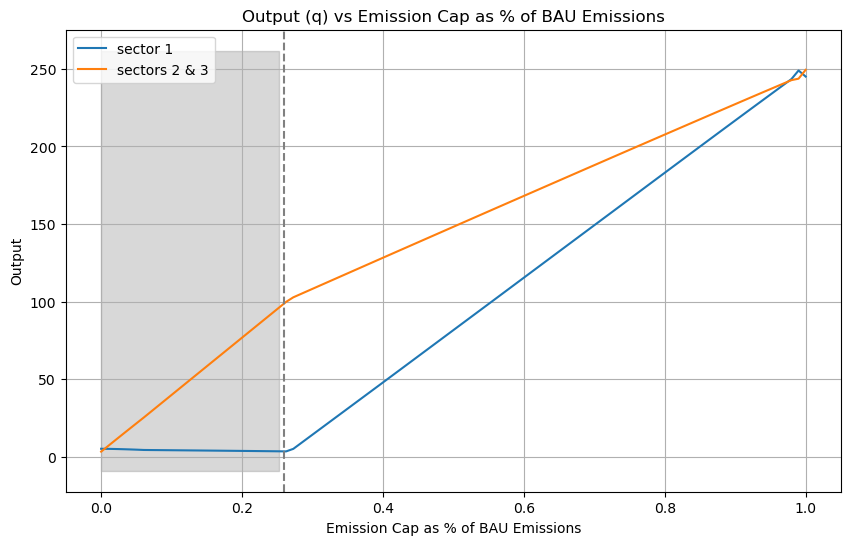

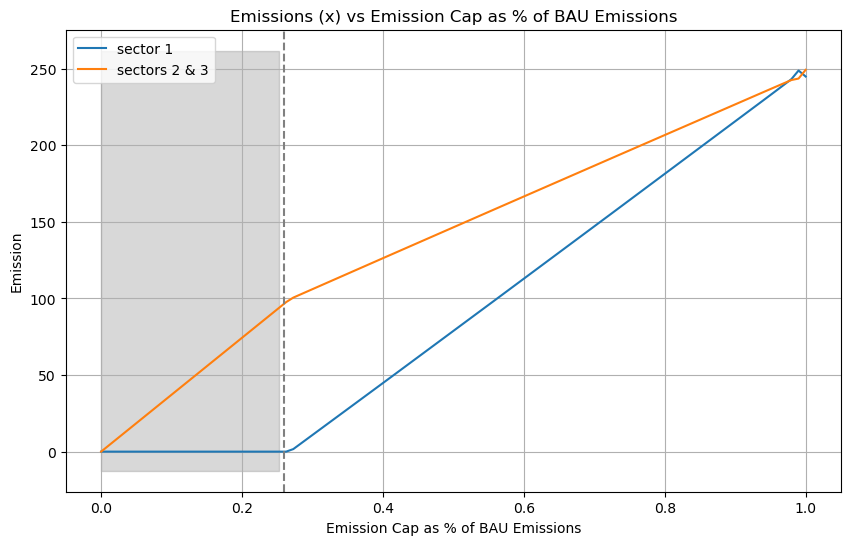

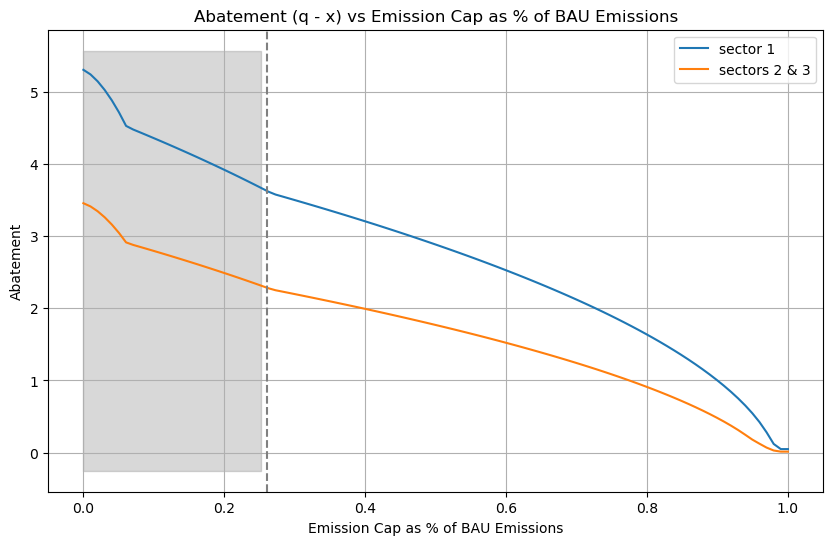

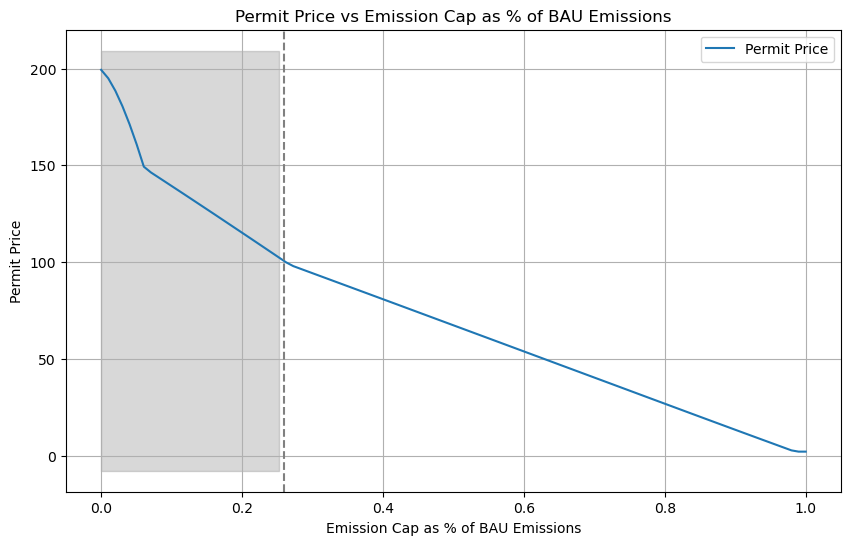

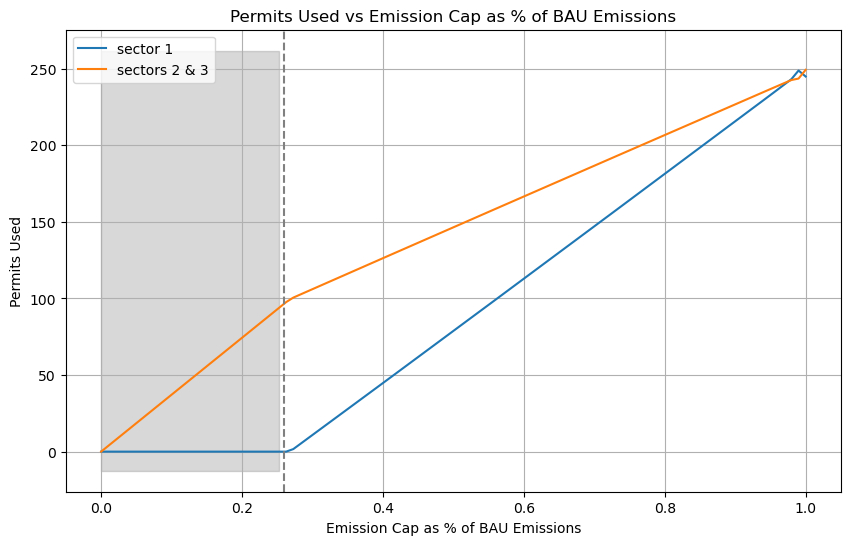

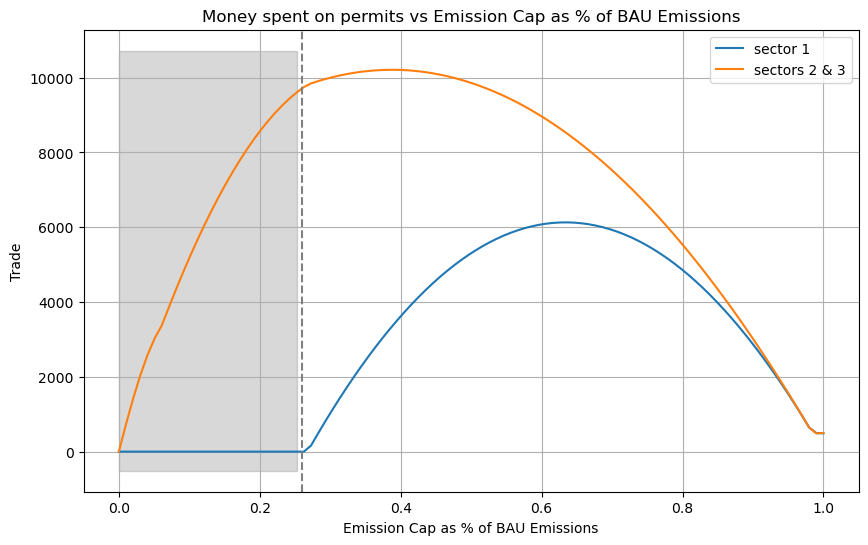

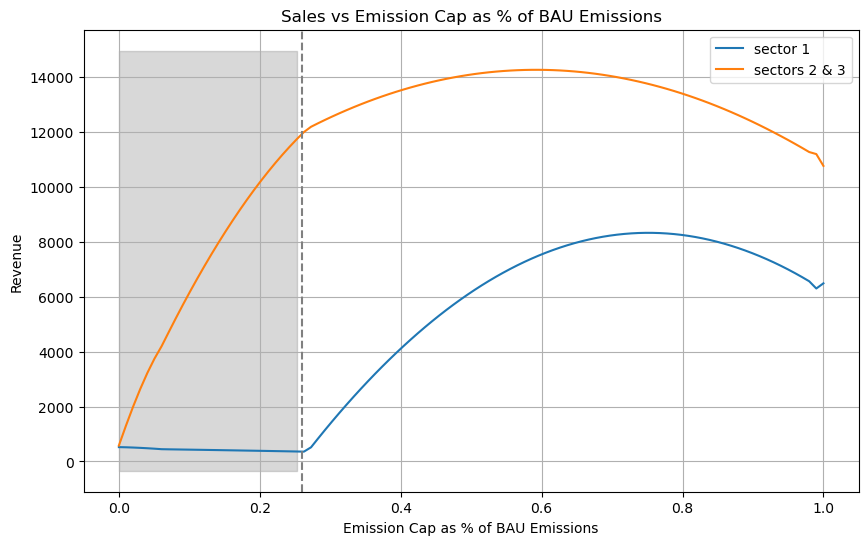

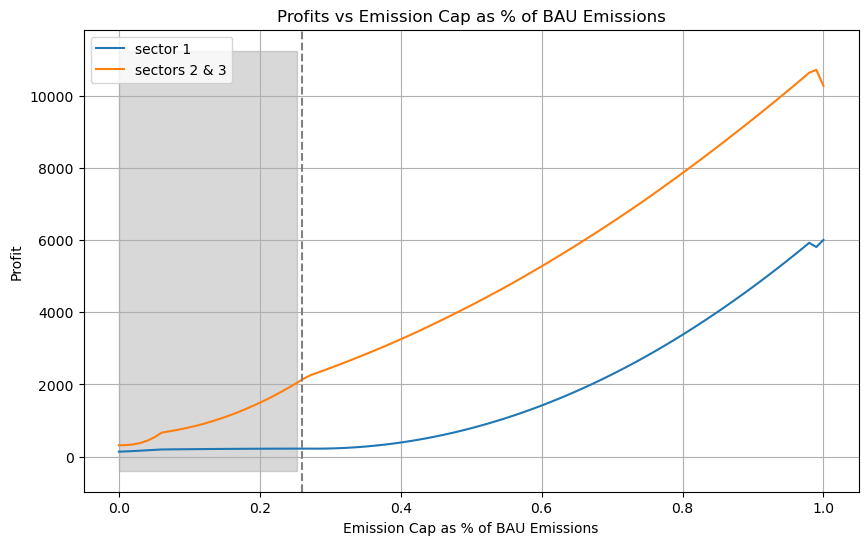

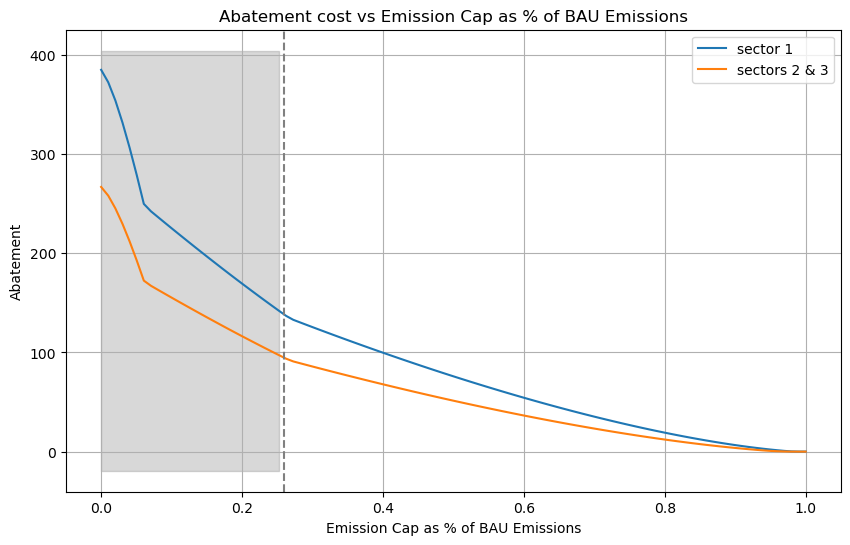

In [6]:
# Define colors
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}

last_wrong_value = 0.26

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label='sector 1', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label='sectors 2 & 3', color=colors['trades2'])
    plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
    plt.xlabel('Emission Cap as % of BAU Emissions')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Emission Cap as % of BAU Emissions')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emissions (x) vs Emission Cap as % of BAU Emissions')

# Plot the difference output - emission to illustrate the abatement
plt.figure(figsize=(10, 6))
plt.plot(frees, np.array(results[True]['outputs1']) - np.array(results[True]['emissions1']), label='sector 1', color=colors['trades1'])
plt.plot(frees, np.array(results[True]['outputs2']) - np.array(results[True]['emissions2']), label='sectors 2 & 3', color=colors['trades2'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Abatement')
plt.title('Abatement (q - x) vs Emission Cap as % of BAU Emissions')
plt.legend()
plt.grid()
plt.show()

# Plot permit prices
plt.figure(figsize=(10, 6))
plt.plot(frees, results[True]['permit_price'], label='Permit Price', color=colors['trades1'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Emission Cap as % of BAU Emissions')
plt.legend()
plt.grid()
plt.show()

# Plot permits used
plot_metric('permits', 'Permits Used', 'Permits Used vs Emission Cap as % of BAU Emissions')

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Emission Cap as % of BAU Emissions')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Emission Cap as % of BAU Emissions')

# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Emission Cap as % of BAU Emissions')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatement cost vs Emission Cap as % of BAU Emissions')

